In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install konlpy pandas scikit-learn keras tensorflow beautifulsoup4 html5lib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 41.3 MB/s eta 0:00:00


In [6]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re

In [3]:
rv_data=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/review_data_saved.csv', encoding='utf-8')

In [17]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = set(file.read().splitlines())
    return stopwords

In [18]:
# 불용어 파일 경로
stopwords_file_path = '/content/drive/MyDrive/Colab_Notebooks/stopwords-ko.txt'

In [19]:
rv_data

,review,sentiment
0,가성비 좋은 가격으로 사서 평상시에 아무때나 입기 정말 좋습니다,1
1,깔끔하고 전체적으로 나쁘지 않았습니다.지금 날씨에 입기 딱좋은듯 합니다,1
2,탄탄하고 아주 깔끔합니다\n세탁 몇번 했는데도 좋아요,1
3,여름에 자주 입을만 한 카라티고 가볍게 외출할때 입어도 괜찮네요,1
4,되게 깔끔하고 카라 깃이 살아있어서 좋았습니다\n다만 기장이 좀 긴듯? 고려해서 사세요,1
...,...,...
3155,172/66 스몰 상체 근육형 잘맞아요 이쁘네요,1
3156,170/67 XL주문했는데 많이 오버하지 않고 좋네요.,1
3157,카라티 하나 필요해서 찾고 있었는데 저렴한 가격에 구매했네요,1
3158,기본 피케셔츠로 딱좋네요ㅎ\n사이즈도 적당하구요,1


In [20]:
# 텍스트 전처리 함수
def preprocessing(review, stopwords, okt, remove_stopwords=True):
    review_text = BeautifulSoup(review, 'html5lib').get_text()  # HTML 태그 제거
    review_text = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣]", " ", review_text)  # 한글 외 공백으로 대체

    if remove_stopwords:
        words = okt.morphs(review_text)  # 형태소 분석
        words = [w for w in words if not w in stopwords]  # 불용어 제거
        review_text = ' '.join(words)

    return review_text

In [21]:
# 불용어 리스트 로드
stopwords = load_stopwords(stopwords_file_path)

In [22]:
# 형태소 분석기 초기화
okt = Okt()

# 리뷰 전처리
list_reviews = list(rv_data['review'])
list_preprocessing_reviews = [preprocessing(review, stopwords, okt) for review in list_reviews]


<ipython-input-20-e3df28e26a37>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review, 'html5lib').get_text()  # HTML 태그 제거


In [23]:
# 전처리된 리뷰와 감정 결합
list_preprocessing_pd = pd.DataFrame({'review': list_preprocessing_reviews, 'sentiment': rv_data['sentiment']})

# 각각의 review와 sentiment를 리스트로 변환
list_reviews = list(list_preprocessing_pd['review'])
list_sentiments = list(list_preprocessing_pd['sentiment'])

# TF-IDF 벡터화
vector = TfidfVectorizer(max_features=5000)
X = vector.fit_transform(list_reviews).toarray()
y = np.array(list_sentiments)

In [47]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [58]:
# k-fold 교차 검증
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # # SMOTE 오버샘플링 적용
    # smote = SMOTE(random_state=42)
    # X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    #오버 샘플링
    ros = RandomOverSampler()
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # 케라스 모델 정의
    model = Sequential()
    model.add(Dense(1, activation='sigmoid', input_dim=X_train_res.shape[1]))

    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

    history = model.fit(X_train_res, y_train_res, validation_data=(X_test, y_test), epochs=50, verbose=0)

    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

20/20 [==============================] - 0s 2ms/step


In [59]:
print(f"Mean Accuracy: {np.mean(accuracies)}")

Mean Accuracy: 0.9639240506329113


In [60]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.23      0.54      0.33        13
           1       0.99      0.96      0.98       619

    accuracy                           0.95       632
   macro avg       0.61      0.75      0.65       632
weighted avg       0.97      0.95      0.96       632



In [73]:
incorrect_indices = np.where((y_pred != y_test) & (y_test == 1))[0]
for idx in incorrect_indices:
    print(f"True Label: {y_test[idx]}, Predicted Label: {y_pred[idx]}, Review Text: {list_reviews[test_index[idx]]}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯어져있네요 자주 이용 했는데 실망 입니다 매우
True Label: 1, Predicted Label: [0], Review Text: 정확히 번 입었는데 옷 뜯

In [62]:
import matplotlib.pyplot as plt

# 학습 곡선 그래프 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

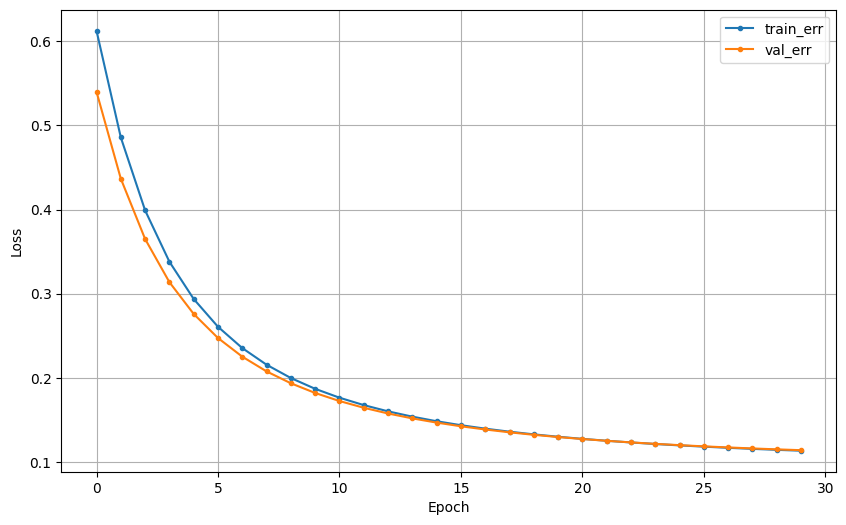

In [63]:
dl_history_plot(hist)